# Flag and Pennant Pattern Recognition in Python

We automate the flag and pennant chart patterns with python and show the code. Then backtest the performance of the patterns. We use the algorithms shown in my previous videos to build rule based pattern recognition. The pattern recognition is rather lenient to detect many patterns. Both of the chart patterns describe a brief interruption in a trend before continuing. A continuation pattern they call it. I show two different identification algorithms. The size of the patterns found can be controlled with a single parameter.  Both pattern recognition systems share similar results. The identified bear and bull flags performed quite well as an entry point for trades using hourly bitcoin data. While the bull and bear pennants are not very consistent. The pennants are found more rarely than the flags. The win rates of the bear and bull flags are above 60% on many of the parameter values and are consistent across parameter values suggesting robustness of the pattern. 

* Tutorial: [Flag and Pennant Pattern Recognition in Python | Algorithmic Trading Strategy](https://www.youtube.com/watch?v=Lb5SPCTp4uY)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from src.perceptually_important import find_pips
from src.rolling_window import rw_top, rw_bottom
from src.trendline_automation import fit_trendlines_single
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
@dataclass
class FlagPattern:
    base_x: int         # Start of the trend index, base of pole
    base_y: float       # Start of trend price

    tip_x: int   = -1       # Tip of pole, start of flag
    tip_y: float = -1.

    conf_x: int   = -1      # Index where pattern is confirmed
    conf_y: float = -1.      # Price where pattern is confirmed

    pennant: bool = False      # True if pennant, false if flag

    flag_width: int    = -1
    flag_height: float = -1.

    pole_width: int    = -1
    pole_height: float = -1.

    # Upper and lower lines for flag, intercept is tip_x
    support_intercept: float = -1.
    support_slope: float = -1.
    resist_intercept: float = -1.
    resist_slope: float = -1.

In [3]:
def check_bear_pattern_pips(pending: FlagPattern, data: np.array, i:int, order:int):
    
    # Find max price since local bottom, (top of pole)
    data_slice = data[pending.base_x: i + 1] # i + 1 includes current price
    min_i = data_slice.argmin() + pending.base_x # Min index since local top
    
    if i - min_i < max(5, order * 0.5): # Far enough from max to draw potential flag/pennant
        return False
    
    # Test flag width / height 
    pole_width = min_i - pending.base_x
    flag_width = i - min_i
    if flag_width > pole_width * 0.5: # Flag should be less than half the width of pole
        return False

    pole_height = pending.base_y - data[min_i] 
    flag_height = data[min_i:i+1].max() - data[min_i] 
    if flag_height > pole_height * 0.5: # Flag should smaller vertically than preceding trend
        return False

    # If here width/height are OK.
    
    # Find perceptually important points from pole to current time
    pips_x, pips_y = find_pips(data[min_i:i+1], 5, 3) # Finds pips between max and current index (inclusive)

    # Check center pip is less than two adjacent. /\/\ 
    if not (pips_y[2] < pips_y[1] and pips_y[2] < pips_y[3]):
        return False
    
    # Find slope and intercept of flag lines
    # intercept is at the max value (top of pole)
    support_rise = pips_y[2] - pips_y[0]
    support_run = pips_x[2] - pips_x[0]
    support_slope = support_rise / support_run
    support_intercept = pips_y[0] 

    resist_rise = pips_y[3] - pips_y[1]
    resist_run = pips_x[3] - pips_x[1]
    resist_slope = resist_rise / resist_run
    resist_intercept = pips_y[1] + (pips_x[0] - pips_x[1]) * resist_slope

    # Find x where two lines intersect.
    #print(pips_x[0], resist_slope, support_slope)
    if resist_slope != support_slope: # Not parallel
        intersection = (support_intercept - resist_intercept) / (resist_slope - support_slope)
        #print("Intersects at", intersection)
    else:
        intersection = -flag_width * 100

    # No intersection in flag area
    if intersection <= pips_x[4] and intersection >= 0:
        return False

    # Check if current point has a breakout of flag. (confirmation)
    support_endpoint = pips_y[0] + support_slope * pips_x[4]
    if pips_y[4] > support_endpoint:
        return False
    
    if resist_slope < 0:
        pending.pennant = True
    else:
        pending.pennant = False
    
    # Filter harshly diverging lines
    if intersection < 0 and intersection > -flag_width:
        return False

    pending.tip_x = min_i
    pending.tip_y = data[min_i]
    pending.conf_x = i
    pending.conf_y = data[i]
    pending.flag_width = flag_width
    pending.flag_height = flag_height
    pending.pole_width = pole_width
    pending.pole_height = pole_height
    pending.support_slope = support_slope
    pending.support_intercept = support_intercept
    pending.resist_slope = resist_slope
    pending.resist_intercept = resist_intercept
    

    return True

In [4]:
def check_bull_pattern_pips(pending: FlagPattern, data: np.array, i:int, order:int):
    
    # Find max price since local bottom, (top of pole)
    data_slice = data[pending.base_x: i + 1] # i + 1 includes current price
    max_i = data_slice.argmax() + pending.base_x # Max index since bottom
    pole_width = max_i - pending.base_x
    
    if i - max_i < max(5, order * 0.5): # Far enough from max to draw potential flag/pennant
        return False

    flag_width = i - max_i
    if flag_width > pole_width * 0.5: # Flag should be less than half the width of pole
        return False

    pole_height = data[max_i] - pending.base_y 
    flag_height = data[max_i] - data[max_i:i+1].min()
    if flag_height > pole_height * 0.5: # Flag should smaller vertically than preceding trend
        return False

    pips_x, pips_y = find_pips(data[max_i:i+1], 5, 3) # Finds pips between max and current index (inclusive)

    # Check center pip is greater than two adjacent. \/\/  
    if not (pips_y[2] > pips_y[1] and pips_y[2] > pips_y[3]):
        return False
        
    # Find slope and intercept of flag lines
    # intercept is at the max value (top of pole)
    resist_rise = pips_y[2] - pips_y[0]
    resist_run = pips_x[2] - pips_x[0]
    resist_slope = resist_rise / resist_run
    resist_intercept = pips_y[0] 

    support_rise = pips_y[3] - pips_y[1]
    support_run = pips_x[3] - pips_x[1]
    support_slope = support_rise / support_run
    support_intercept = pips_y[1] + (pips_x[0] - pips_x[1]) * support_slope

    # Find x where two lines intersect.
    if resist_slope != support_slope: # Not parallel
        intersection = (support_intercept - resist_intercept) / (resist_slope - support_slope)
    else:
        intersection = -flag_width * 100

    # No intersection in flag area
    if intersection <= pips_x[4] and intersection >= 0:
        return False
    
    # Filter harshly diverging lines
    if intersection < 0 and intersection > -1.0 * flag_width:
        return False

    # Check if current point has a breakout of flag. (confirmation)
    resist_endpoint = pips_y[0] + resist_slope * pips_x[4]
    if pips_y[4] < resist_endpoint:
        return False

    # Pattern is confiremd, fill out pattern details in pending
    if support_slope > 0:
        pending.pennant = True
    else:
        pending.pennant = False

    pending.tip_x = max_i
    pending.tip_y = data[max_i]
    pending.conf_x = i
    pending.conf_y = data[i]
    pending.flag_width = flag_width
    pending.flag_height = flag_height
    pending.pole_width = pole_width
    pending.pole_height = pole_height
    
    pending.support_slope = support_slope
    pending.support_intercept = support_intercept
    pending.resist_slope = resist_slope
    pending.resist_intercept = resist_intercept
    
    return True

In [5]:
def find_flags_pennants_pips(data: np.array, order:int):
    assert(order >= 3)
    pending_bull = None # Pending pattern
    pending_bear = None # Pending pattern

    bull_pennants = []
    bear_pennants = []
    bull_flags = []
    bear_flags = []
    for i in range(len(data)):

        # Pattern data is organized like so:
        if rw_top(data, i, order):
            pending_bear = FlagPattern(i - order, data[i - order])
        
        if rw_bottom(data, i, order):
            pending_bull = FlagPattern(i - order, data[i - order])

        if pending_bear is not None:
            if check_bear_pattern_pips(pending_bear, data, i, order):
                if pending_bear.pennant:
                    bear_pennants.append(pending_bear)
                else:
                    bear_flags.append(pending_bear)
                pending_bear = None

        if pending_bull is not None:
            if check_bull_pattern_pips(pending_bull, data, i, order):
                if pending_bull.pennant:
                    bull_pennants.append(pending_bull)
                else:
                    bull_flags.append(pending_bull)
                pending_bull = None

    return bull_flags, bear_flags, bull_pennants, bear_pennants

In [6]:
def check_bull_pattern_trendline(pending: FlagPattern, data: np.array, i:int, order:int):
    
    # Check if data max less than pole tip 
    if data[pending.tip_x + 1 : i].max() > pending.tip_y:
        return False

    flag_min = data[pending.tip_x:i].min()

    # Find flag/pole height and width
    pole_height = pending.tip_y - pending.base_y
    pole_width = pending.tip_x - pending.base_x
    
    flag_height = pending.tip_y - flag_min
    flag_width = i - pending.tip_x

    if flag_width > pole_width * 0.5: # Flag should be less than half the width of pole
        return False

    if flag_height > pole_height * 0.75: # Flag should smaller vertically than preceding trend
        return False

    # Find trendlines going from flag tip to the previous bar (not including current bar)
    support_coefs, resist_coefs = fit_trendlines_single(data[pending.tip_x:i])
    support_slope, support_intercept = support_coefs[0], support_coefs[1]
    resist_slope, resist_intercept = resist_coefs[0], resist_coefs[1]

    # Check for breakout of upper trendline to confirm pattern
    current_resist = resist_intercept + resist_slope * (flag_width + 1)
    if data[i] <= current_resist:
        return False

    # Pattern is confiremd, fill out pattern details in pending
    if support_slope > 0:
        pending.pennant = True
    else:
        pending.pennant = False

    pending.conf_x = i
    pending.conf_y = data[i]
    pending.flag_width = flag_width
    pending.flag_height = flag_height
    pending.pole_width = pole_width
    pending.pole_height = pole_height
    
    pending.support_slope = support_slope
    pending.support_intercept = support_intercept
    pending.resist_slope = resist_slope
    pending.resist_intercept = resist_intercept

    return True

In [7]:
def check_bear_pattern_trendline(pending: FlagPattern, data: np.array, i:int, order:int):
    # Check if data max less than pole tip 
    if data[pending.tip_x + 1 : i].min() < pending.tip_y:
        return False

    flag_max = data[pending.tip_x:i].max()

    # Find flag/pole height and width
    pole_height = pending.base_y - pending.tip_y
    pole_width = pending.tip_x - pending.base_x
    
    flag_height = flag_max - pending.tip_y
    flag_width = i - pending.tip_x

    if flag_width > pole_width * 0.5: # Flag should be less than half the width of pole
        return False

    if flag_height > pole_height * 0.75: # Flag should smaller vertically than preceding trend
        return False

    # Find trendlines going from flag tip to the previous bar (not including current bar)
    support_coefs, resist_coefs = fit_trendlines_single(data[pending.tip_x:i])
    support_slope, support_intercept = support_coefs[0], support_coefs[1]
    resist_slope, resist_intercept = resist_coefs[0], resist_coefs[1]

    # Check for breakout of lower trendline to confirm pattern
    current_support = support_intercept + support_slope * (flag_width + 1)
    if data[i] >= current_support:
        return False

    # Pattern is confiremd, fill out pattern details in pending
    if resist_slope < 0:
        pending.pennant = True
    else:
        pending.pennant = False

    pending.conf_x = i
    pending.conf_y = data[i]
    pending.flag_width = flag_width
    pending.flag_height = flag_height
    pending.pole_width = pole_width
    pending.pole_height = pole_height
    
    pending.support_slope = support_slope
    pending.support_intercept = support_intercept
    pending.resist_slope = resist_slope
    pending.resist_intercept = resist_intercept

    return True

In [8]:
def find_flags_pennants_trendline(data: np.array, order:int):
    assert(order >= 3)
    pending_bull = None # Pending pattern
    pending_bear = None  # Pending pattern

    last_bottom = -1
    last_top = -1

    bull_pennants = []
    bear_pennants = []
    bull_flags = []
    bear_flags = []
    for i in range(len(data)):

        # Pattern data is organized like so:
        if rw_top(data, i, order):
            last_top = i - order
            if last_bottom != -1:
                pending = FlagPattern(last_bottom, data[last_bottom])
                pending.tip_x = last_top
                pending.tip_y = data[last_top]
                pending_bull = pending
        
        if rw_bottom(data, i, order):
            last_bottom = i - order
            if last_top != -1:
                pending = FlagPattern(last_top, data[last_top])
                pending.tip_x = last_bottom
                pending.tip_y = data[last_bottom]
                pending_bear = pending

        if pending_bear is not None:
            if check_bear_pattern_trendline(pending_bear, data, i, order):
                if pending_bear.pennant:
                    bear_pennants.append(pending_bear)
                else:
                    bear_flags.append(pending_bear)
                pending_bear = None
        
        if pending_bull is not None:
            if check_bull_pattern_trendline(pending_bull, data, i, order):
                if pending_bull.pennant:
                    bull_pennants.append(pending_bull)
                else:
                    bull_flags.append(pending_bull)
                pending_bull = None

    return bull_flags, bear_flags, bull_pennants, bear_pennants

In [9]:
def plot_flag(candle_data: pd.DataFrame, pattern: FlagPattern, pad=2):
    if pad < 0:
        pad = 0

    start_i = pattern.base_x - pad
    end_i = pattern.conf_x + 1 + pad
    dat = candle_data.iloc[start_i:end_i]
    idx = dat.index
    
    plt.style.use('dark_background')
    fig = plt.gcf()
    ax = fig.gca()

    tip_idx = idx[pattern.tip_x - start_i]
    conf_idx = idx[pattern.conf_x - start_i]

    pole_line = [(idx[pattern.base_x - start_i], pattern.base_y), (tip_idx, pattern.tip_y)]
    upper_line = [(tip_idx, pattern.resist_intercept), (conf_idx, pattern.resist_intercept + pattern.resist_slope * pattern.flag_width)]
    lower_line = [(tip_idx, pattern.support_intercept), (conf_idx, pattern.support_intercept + pattern.support_slope * pattern.flag_width)]

    mpf.plot(dat, alines=dict(alines=[pole_line, upper_line, lower_line], colors=['w', 'b', 'b']), type='candle', style='charles', ax=ax)
    plt.show()

In [10]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [11]:
data = np.log(data)
dat_slice = data['close'].to_numpy()

In [12]:
# Main

#bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_pips(dat_slice, 12)
bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_trendline(dat_slice, 10)

bull_flag_df = pd.DataFrame()
bull_pennant_df = pd.DataFrame()
bear_flag_df = pd.DataFrame()
bear_pennant_df = pd.DataFrame()

# Assemble data into dataframe
hold_mult = 1.0 # Multipler of flag width to hold for after a pattern
for i, flag in enumerate(bull_flags):
    bull_flag_df.loc[i, 'flag_width'] = flag.flag_width
    bull_flag_df.loc[i, 'flag_height'] = flag.flag_height
    bull_flag_df.loc[i, 'pole_width'] = flag.pole_width
    bull_flag_df.loc[i, 'pole_height'] = flag.pole_height
    bull_flag_df.loc[i, 'slope'] = flag.resist_slope

    hp = int(flag.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bull_flag_df.loc[i, 'return'] = np.nan
    else:
        ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
        bull_flag_df.loc[i, 'return'] = ret 

for i, flag in enumerate(bear_flags):
    bear_flag_df.loc[i, 'flag_width'] = flag.flag_width
    bear_flag_df.loc[i, 'flag_height'] = flag.flag_height
    bear_flag_df.loc[i, 'pole_width'] = flag.pole_width
    bear_flag_df.loc[i, 'pole_height'] = flag.pole_height
    bear_flag_df.loc[i, 'slope'] = flag.support_slope

    hp = int(flag.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bear_flag_df.loc[i, 'return'] = np.nan
    else:
        ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
        bear_flag_df.loc[i, 'return'] = ret 

for i, pennant in enumerate(bull_pennants):
    bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
    bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
    bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
    bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

    hp = int(pennant.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bull_pennant_df.loc[i, 'return'] = np.nan
    else:
        ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
        bull_pennant_df.loc[i, 'return'] = ret 

for i, pennant in enumerate(bear_pennants):
    bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
    bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
    bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
    bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

    hp = int(pennant.flag_width * hold_mult)
    if flag.conf_x + hp >= len(data):
        bear_pennant_df.loc[i, 'return'] = np.nan
    else:
        ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
        bear_pennant_df.loc[i, 'return'] = ret 

In [13]:
bull_flag_df

,flag_width,flag_height,pole_width,pole_height,slope,return
0,10.0,0.040361,21.0,0.098289,-0.003873,-0.149596
1,10.0,0.054841,26.0,0.101209,-0.004462,-0.006885
2,10.0,0.036459,45.0,0.152459,-0.003360,-0.024619
3,11.0,0.086305,34.0,0.315505,-0.003150,0.002451
4,11.0,0.055919,25.0,0.100463,-0.003776,0.005677
...,...,...,...,...,...,...
246,10.0,0.009020,27.0,0.026703,-0.000940,0.000522
247,10.0,0.014304,35.0,0.057219,-0.000756,0.002267
248,10.0,0.032449,64.0,0.074683,-0.002991,-0.014402
249,13.0,0.001998,26.0,0.003955,-0.000094,0.003892


In [14]:
# Test

orders = list(range(3, 49))
bull_flag_wr = []
bull_pennant_wr = []
bear_flag_wr = []
bear_pennant_wr = []

bull_flag_avg = []
bull_pennant_avg = []
bear_flag_avg = []
bear_pennant_avg = []

bull_flag_count = []
bull_pennant_count = []
bear_flag_count = []
bear_pennant_count = []

bull_flag_total_ret = []
bull_pennant_total_ret = []
bear_flag_total_ret = []
bear_pennant_total_ret = []

for order in tqdm(orders):
    bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_pips(dat_slice, order)
    #bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_trendline(dat_slice, order)

    bull_flag_df = pd.DataFrame()
    bull_pennant_df = pd.DataFrame()
    bear_flag_df = pd.DataFrame()
    bear_pennant_df = pd.DataFrame()

    # Assemble data into dataframe
    hold_mult = 1.0 # Multipler of flag width to hold for after a pattern
    for i, flag in enumerate(bull_flags):
        bull_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bull_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bull_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bull_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bull_flag_df.loc[i, 'slope'] = flag.resist_slope

        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bull_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
            bull_flag_df.loc[i, 'return'] = ret 

    for i, flag in enumerate(bear_flags):
        bear_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bear_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bear_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bear_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bear_flag_df.loc[i, 'slope'] = flag.support_slope

        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bear_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
            bear_flag_df.loc[i, 'return'] = ret 

    for i, pennant in enumerate(bull_pennants):
        bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bull_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
            bull_pennant_df.loc[i, 'return'] = ret 

    for i, pennant in enumerate(bear_pennants):
        bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bear_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
            bear_pennant_df.loc[i, 'return'] = ret 

    if len(bull_flag_df) > 0:
        bull_flag_count.append(len(bull_flag_df))
        bull_flag_avg.append(bull_flag_df['return'].mean())
        bull_flag_wr.append(len(bull_flag_df[bull_flag_df['return'] > 0]) / len(bull_flag_df))
        bull_flag_total_ret.append(bull_flag_df['return'].sum())
    else:
        bull_flag_count.append(0)
        bull_flag_avg.append(np.nan)
        bull_flag_wr.append(np.nan)
        bull_flag_total_ret.append(0)
    
    if len(bear_flag_df) > 0:
        bear_flag_count.append(len(bear_flag_df))
        bear_flag_avg.append(bear_flag_df['return'].mean())
        bear_flag_wr.append(len(bear_flag_df[bear_flag_df['return'] > 0]) / len(bear_flag_df))
        bear_flag_total_ret.append(bear_flag_df['return'].sum())
    else:
        bear_flag_count.append(0)
        bear_flag_avg.append(np.nan)
        bear_flag_wr.append(np.nan)
        bear_flag_total_ret.append(0)
    
    if len(bull_pennant_df) > 0:
        bull_pennant_count.append(len(bull_pennant_df))
        bull_pennant_avg.append(bull_pennant_df['return'].mean())
        bull_pennant_wr.append(len(bull_pennant_df[bull_pennant_df['return'] > 0]) / len(bull_pennant_df))
        bull_pennant_total_ret.append(bull_pennant_df['return'].sum())
    else:
        bull_pennant_count.append(0)
        bull_pennant_avg.append(np.nan)
        bull_pennant_wr.append(np.nan)
        bull_pennant_total_ret.append(0)
    
    if len(bear_pennant_df) > 0:
        bear_pennant_count.append(len(bear_pennant_df))
        bear_pennant_avg.append(bear_pennant_df['return'].mean())
        bear_pennant_wr.append(len(bear_pennant_df[bear_pennant_df['return'] > 0]) / len(bear_pennant_df))
        bear_pennant_total_ret.append(bear_pennant_df['return'].sum())
    else:
        bear_pennant_count.append(0)
        bear_pennant_avg.append(np.nan)
        bear_pennant_wr.append(np.nan)
        bear_pennant_total_ret.append(0)

100%|███████████████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  3.93it/s]


In [15]:
results_df = pd.DataFrame(index=orders)
results_df['bull_flag_count'] = bull_flag_count
results_df['bull_flag_avg'] = bull_flag_avg
results_df['bull_flag_wr'] = bull_flag_wr
results_df['bull_flag_total'] = bull_flag_total_ret

results_df['bear_flag_count'] = bear_flag_count
results_df['bear_flag_avg'] = bear_flag_avg
results_df['bear_flag_wr'] = bear_flag_wr
results_df['bear_flag_total'] = bear_flag_total_ret

results_df['bull_pennant_count'] = bull_pennant_count
results_df['bull_pennant_avg'] = bull_pennant_avg
results_df['bull_pennant_wr'] = bull_pennant_wr
results_df['bull_pennant_total'] = bull_pennant_total_ret

results_df['bear_pennant_count'] = bear_pennant_count
results_df['bear_pennant_avg'] = bear_pennant_avg
results_df['bear_pennant_wr'] = bear_pennant_wr
results_df['bear_pennant_total'] = bear_pennant_total_ret

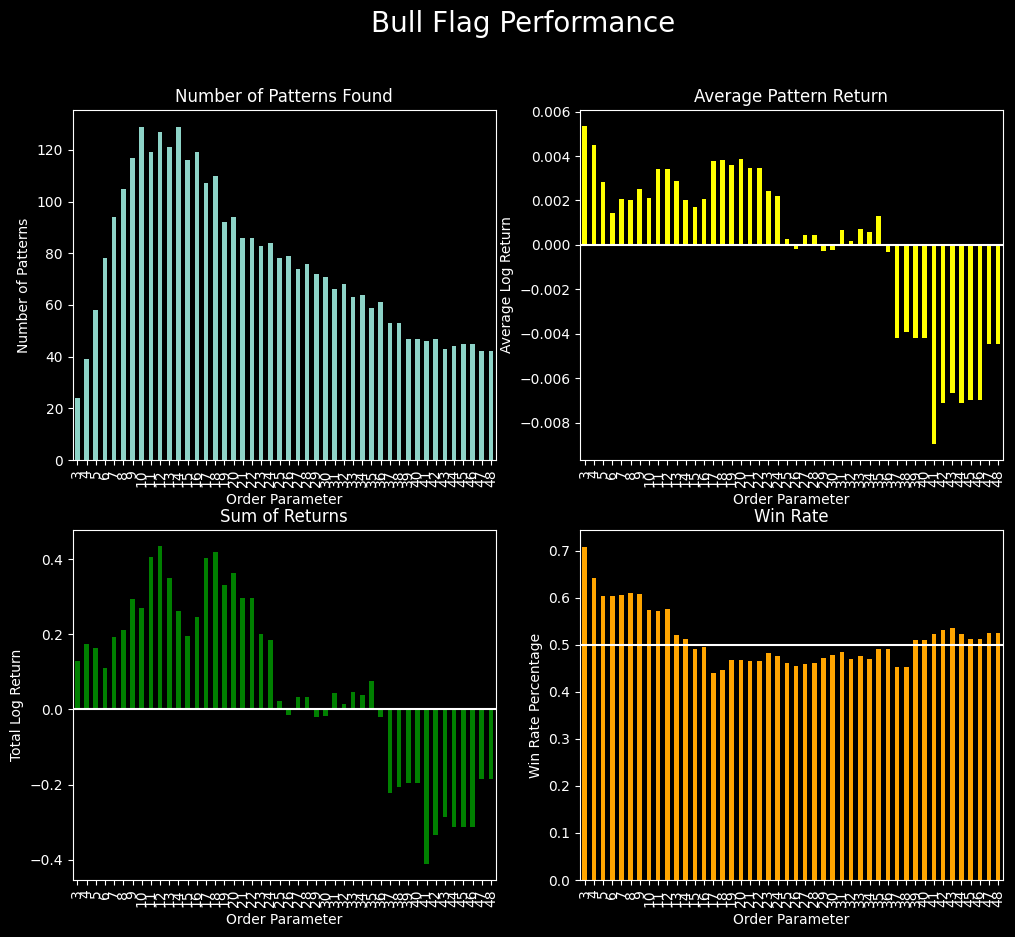

In [16]:
# Plot bull flag results
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Bull Flag Performance", fontsize=20)
results_df['bull_flag_count'].plot.bar(ax=ax[0,0])
results_df['bull_flag_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bull_flag_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bull_flag_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

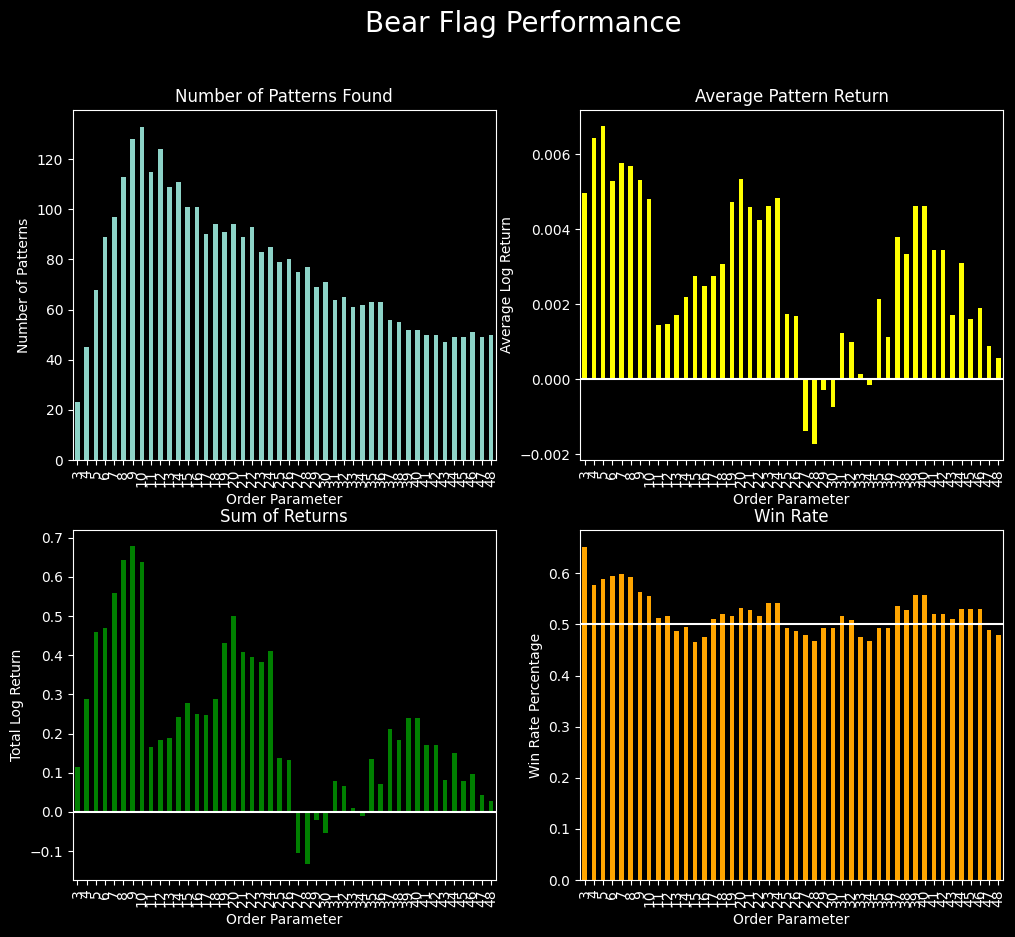

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Bear Flag Performance", fontsize=20)
results_df['bear_flag_count'].plot.bar(ax=ax[0,0])
results_df['bear_flag_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bear_flag_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bear_flag_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

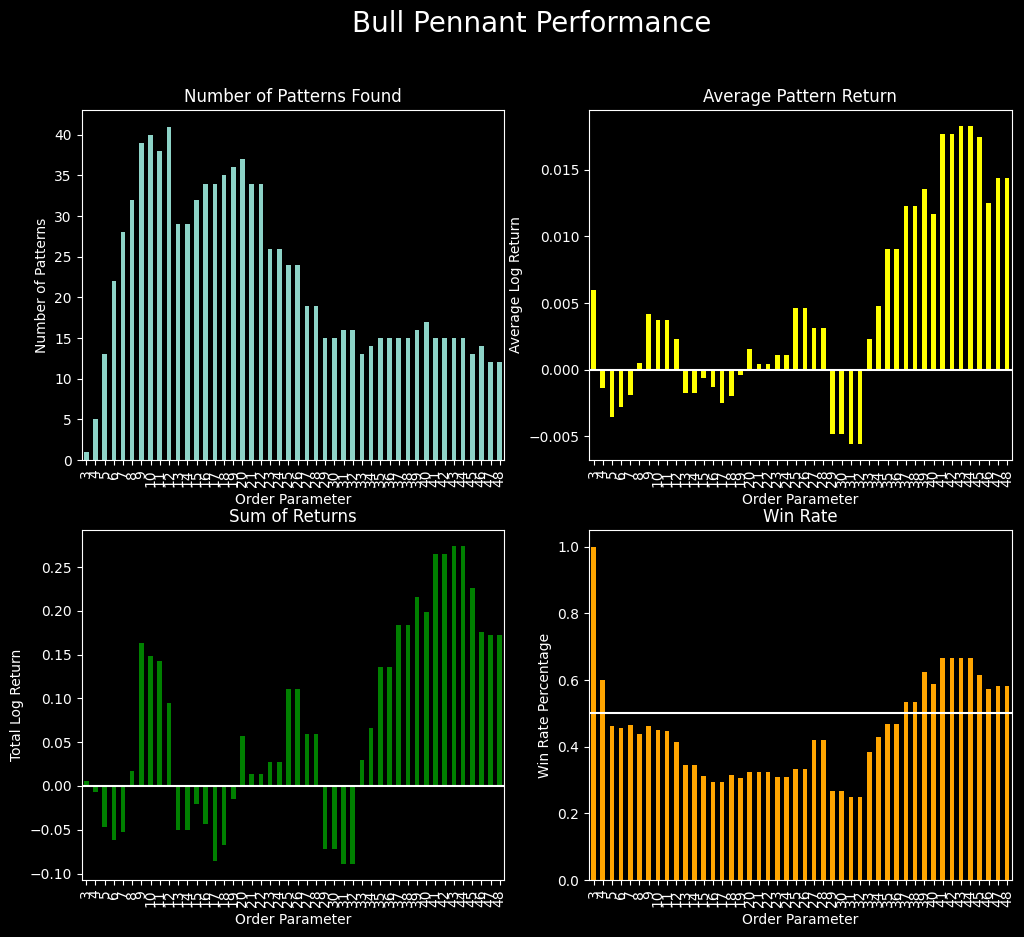

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Bull Pennant Performance", fontsize=20)
results_df['bull_pennant_count'].plot.bar(ax=ax[0,0])
results_df['bull_pennant_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bull_pennant_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bull_pennant_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

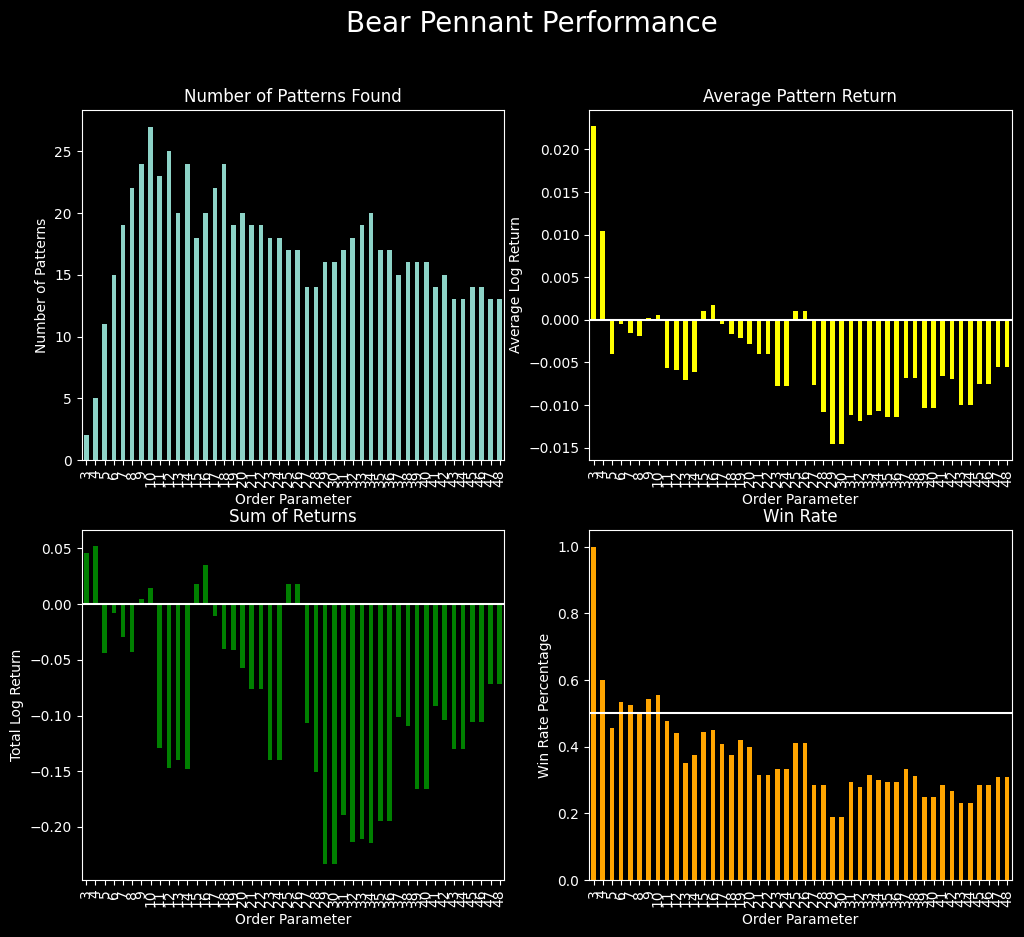

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Bear Pennant Performance", fontsize=20)
results_df['bear_pennant_count'].plot.bar(ax=ax[0,0])
results_df['bear_pennant_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bear_pennant_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bear_pennant_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()